In [1]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import create_optimizer
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
MODEL_NAME = "./models/bert-base-chinese/"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5

In [3]:
def load_dataset(tabel='train'):
    file = './datasets/'+tabel+'.tsv'
    df = pd.read_csv(file, sep='\t')
    df = df.dropna()
    texts = df['text_a'].astype(str).tolist()
    if tabel == 'test':
        labels = None
    else:
        labels = df['label'].astype(int).tolist()
        
    return texts, labels

def split_data(x, y, split_size=0.3):
    data_size = len(x)
    train_size = int(data_size*(1-split_size))
    train_x = x[:train_size]
    train_y = y[:train_size]
    val_x = x[train_size:]
    val_y = y[train_size:]

    return (train_x, train_y), (val_x, val_y)

In [4]:
train_texts, train_labels = load_dataset('train')
test_texts, test_labels = load_dataset('dev')
pred_texts, _ = load_dataset('test')

In [5]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [6]:
def encode_texts(texts, labels):
    encodings = tokenizer(
        texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="tf"
    )
    return tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))

In [7]:
train_ds = encode_texts(train_texts, train_labels).shuffle(1000).batch(BATCH_SIZE)
test_ds = encode_texts(test_texts,test_labels).batch(BATCH_SIZE)

In [9]:
model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

Some layers from the model checkpoint at ./models/bert-base-chinese/ were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ./models/bert-base-chinese/ and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
steps_per_epoch = len(train_ds)
num_train_steps = steps_per_epoch * EPOCHS
optimizer, schedule = create_optimizer(init_lr=LR, num_warmup_steps=0, num_train_steps=num_train_steps)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

In [12]:
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)

Epoch 1/3
572/572 [==============================] - 411s 697ms/step - loss: 0.3200 - accuracy: 0.8717 - val_loss: 0.1991 - val_accuracy: 0.9225
Epoch 2/3
572/572 [==============================] - 347s 607ms/step - loss: 0.1402 - accuracy: 0.9485 - val_loss: 0.1961 - val_accuracy: 0.9400
Epoch 3/3
572/572 [==============================] - 124s 217ms/step - loss: 0.0635 - accuracy: 0.9791 - val_loss: 0.2026 - val_accuracy: 0.9433


训练曲线已保存 bert_finetune_loss_and_accuracy.png


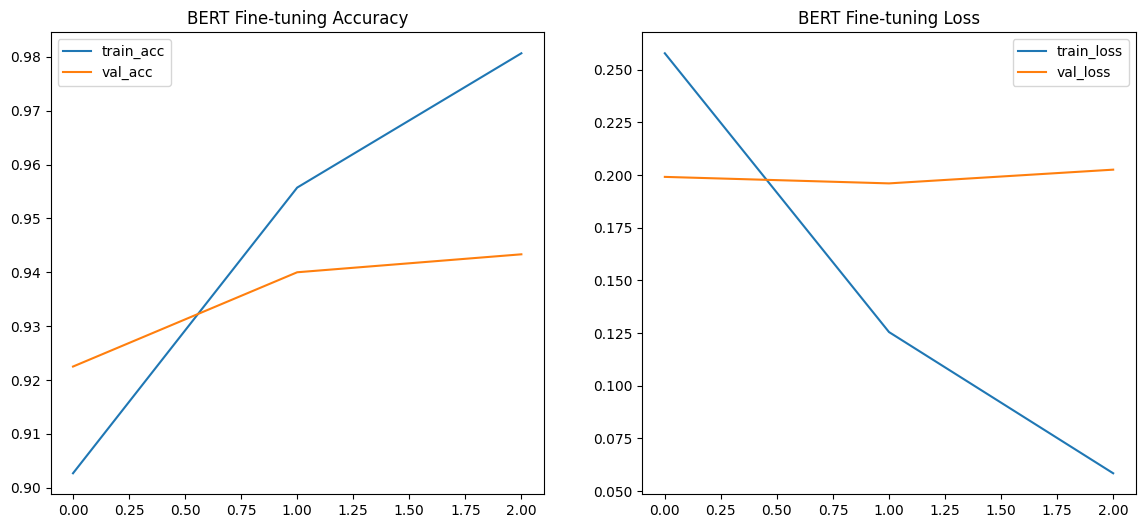

In [15]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("BERT Fine-tuning Accuracy")
plt.legend()
plt.subplot(122)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("BERT Fine-tuning Loss")
plt.legend()
plt.savefig("bert_finetune_loss_and_accuracy.png")
print("训练曲线已保存 bert_finetune_loss_and_accuracy.png")

In [16]:
os.makedirs("models/bert_finetuned", exist_ok=True)
model.save_pretrained("models/bert_finetuned")
tokenizer.save_pretrained("models/bert_finetuned")
print("模型已保存到 models/bert_finetuned")

模型已保存到 models/bert_finetuned


In [17]:
MODEL_PATH = "models/bert_finetuned"
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
model = TFBertForSequenceClassification.from_pretrained(MODEL_PATH)

Some layers from the model checkpoint at models/bert_finetuned were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at models/bert_finetuned and are newly initialized: ['dropout_75']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
def predict(texts):
    encodings = tokenizer(
        texts, truncation=True, padding=True, max_length=MAX_LEN, return_tensors="tf"
    )
    inputs = dict(encodings)
    outputs = model.predict(inputs)
    logits = outputs.logits
    pred = tf.nn.softmax(logits,axis=1)
    label = tf.argmax(pred, axis=1).numpy()
    return list(zip(texts, list(label)))

In [20]:
preds = predict(pred_texts)

In [21]:
preds[:10]

[('这个宾馆比较陈旧了，特价的房间也很一般。总体来说一般', 0),
 ('怀着十分激动的心情放映，可是看着看着发现，在放映完毕后，出现一集米老鼠的动画片！开始还怀疑是不是赠送的个别现象，可是后来发现每张DVD后面都有！真不知道生产商怎么想的，我想看的是猫和老鼠，不是米老鼠！如果厂家是想赠送的话，那就全套米老鼠和唐老鸭都赠送，只在每张DVD后面添加一集算什么？？简直是画蛇添足！！',
  0),
 ('还稍微重了点，可能是硬盘大的原故，还要再轻半斤就好了。其他要进一步验证。贴的几种膜气泡较多，用不了多久就要更换了，屏幕膜稍好点，但比没有要强多了。建议配赠几张膜让用用户自己贴。',
  0),
 ('交通方便；环境很好；服务态度很好 房间较小', 1),
 ('不错，作者的观点很颠覆目前中国父母的教育方式，其实古人们对于教育已经有了很系统的体系了，可是现在的父母以及祖父母们更多的娇惯纵容孩子，放眼看去自私的孩子是大多数，父母觉得自己的孩子在外面只要不吃亏就是好事，完全把古人几千年总结的教育古训抛在的九霄云外。所以推荐准妈妈们可以在等待宝宝降临的时候，好好学习一下，怎么把孩子教育成一个有爱心、有责任心、宽容、大度的人。',
  1),
 ('有了第一本书的铺垫，读第二本的时候开始进入状态。基本上第二本就围绕主角们的能力训练展开，故事的主要发生场地设置在美洲的亚马逊丛林。心里一直疑惑这和西藏有什么关系，不过大概看完全书才能知道内里的线索。其中描述了很多热带雨林中特有的神秘动植物以及一些生存技巧和常识，受益匪浅。能够想像出要写这样一部书，融合这样许多的知识，作者需要花费多少心血来搜集和整理并成文。',
  1),
 ('前台接待太差，酒店有A B楼之分，本人check－in后，前台未告诉B楼在何处，并且B楼无明显指示；房间太小，根本不像4星级设施，下次不会再选择入住此店啦。',
  0),
 ('1. 白色的，很漂亮，做工还可以； 2. 网上的软件资源非常丰富，这是我买它的最主要原因； 3. 电池不错，昨天从下午两点到晚上十点还有25分钟的剩余时间（关闭摄像头，无线和蓝牙）主要拷贝东西，看起来正常使用八小时左右没问题； 4. 散热不错，CPU核心不过40~55度，很多小本要上到80度了； 5. 变压器很小巧，很多小本的电源都用的是大本的电源，本倒是很轻，可旅行重量还是比较